In [156]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN, GAT
from stellargraph import globalvar

from stellargraph.ensemble import Ensemble, BaggingEnsemble

from tensorflow.keras import layers, optimizers, losses, metrics, Model, models, regularizers
from sklearn import preprocessing, feature_extraction, model_selection

import matplotlib.pyplot as plt
import seaborn as sns
from stellargraph import datasets
from IPython.display import display, HTML


%matplotlib inline

In [157]:
use_bagging = 1
n_estimators = 5
n_predictions = 10
epochs = 50
dataset = 'Cora' 

In [158]:
if dataset == 'Cora':
    dataset = datasets.Cora()
elif dataset == 'PubMed':
    dataset = datasets.PubMedDiabetes()
    
elif dataset == 'CiteSeer':
    dataset = datasets.CiteSeer()
    

In [159]:
display(HTML(dataset.description))
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [160]:
G, labels = dataset.load()
print(set(labels))


{'Theory', 'Genetic_Algorithms', 'Neural_Networks', 'Rule_Learning', 'Reinforcement_Learning', 'Case_Based', 'Probabilistic_Methods'}


In [161]:
train_labels, test_labels = model_selection.train_test_split(
    labels, train_size=0.2, test_size=None, stratify=labels, random_state=42,  # 140
)
val_labels, test_labels = model_selection.train_test_split(
    test_labels,
    train_size=0.2,  # 500,
    test_size=None,
    stratify=test_labels,
    random_state=100,
)

In [162]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_labels)
val_targets = target_encoding.transform(val_labels)
test_targets = target_encoding.transform(test_labels)

In [163]:
generator = FullBatchNodeGenerator(G, method="sgc", k=4)


Calculating 4-th power of normalized A...


In [164]:
train_gen = generator.flow(train_labels.index, train_targets)

In [165]:
sgc = GCN(
    layer_sizes=[train_targets.shape[1]],
    generator=generator,
    bias=True,
    dropout=0.5,
    activations=["softmax"],
    kernel_regularizer=regularizers.l2(5e-4),
)

In [166]:
# Expose the input and output tensors of the SGC model for node prediction,
# via GCN.in_out_tensors() method:
x_inp, predictions = sgc.in_out_tensors()

In [167]:
model = Model(inputs=x_inp, outputs=predictions)

In [168]:
if use_bagging:
    model = BaggingEnsemble(model, n_estimators=n_estimators, n_predictions=n_predictions)
else:
    model = Ensemble(model, n_estimators=n_estimators, n_predictions=n_predictions)

model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

model

C:\Users\bilal\AppData\Roaming\Python\Python37\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [169]:
model.layers(0)

In [170]:
val_gen = generator.flow(val_labels.index, val_targets)
test_gen = generator.flow(test_labels.index, test_targets)

In [171]:
if use_bagging:
    # When using bootstrap samples to train each model in the ensemble, we must specify
    # the IDs of the training nodes (train_data) and their corresponding target values
    # (train_targets)
    history = model.fit(
        generator,
        train_data=train_labels.index,
        train_targets=train_targets,
        epochs=epochs,
        validation_data=val_gen,
        verbose=0,
        shuffle=False,
        bag_size=None,
        use_early_stopping=True,  # Enable early stopping
        early_stopping_monitor="val_acc",
    )
else:
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        verbose=0,
        shuffle=False,
        use_early_stopping=True,  # Enable early stopping
        early_stopping_monitor="val_acc",
    )

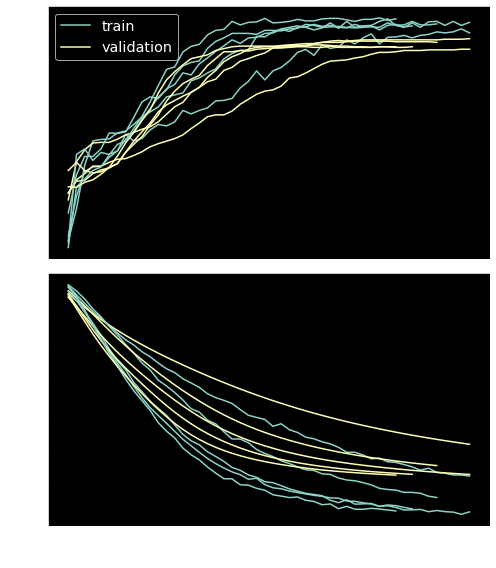

In [172]:
sg.utils.plot_history(history)

In [173]:
test_metrics_mean, test_metrics_std = model.evaluate(test_gen)
model.metrics_names = ['loss', 'accuracy']

print("\nTest Set Metrics of the trained models:")
for name, m, s in zip(model.metrics_names, test_metrics_mean, test_metrics_std):
    print("\t{}: {:0.4f}±{:0.4f}".format(name, m, s))


Test Set Metrics of the trained models:
	loss: 0.9466±0.0628
	accuracy: 0.8339±0.0113


In [117]:
all_nodes = labels.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(generator=all_gen)

print(all_predictions.shape)
all_predictions = np.squeeze(all_predictions)
print(all_predictions.shape)
node_predictions = target_encoding.inverse_transform(all_predictions)

selected_query_point = -1
# Select the predictions for the point specified by selected_query_point
qp_predictions = all_predictions[:, :, selected_query_point, :]
# The shape should be n_estimators x n_predictions x size_output_layer
qp_predictions.shape

qp_predictions = qp_predictions.reshape(
    np.product(qp_predictions.shape[0:-1]), qp_predictions.shape[-1]
)
qp_predictions.shape

(5, 10, 1, 2708, 7)
(5, 10, 2708, 7)


(50, 7)

In [64]:
inv_subject_mapper = {k: v for k, v in enumerate(target_encoding.classes_)}
inv_subject_mapper

{0: 'Case_Based',
 1: 'Genetic_Algorithms',
 2: 'Neural_Networks',
 3: 'Probabilistic_Methods',
 4: 'Reinforcement_Learning',
 5: 'Rule_Learning',
 6: 'Theory'}

Text(0.5, 0, 'Subject')

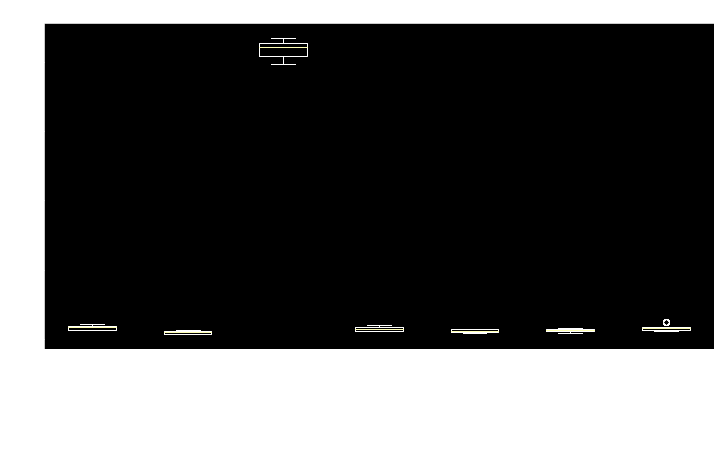

In [65]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(x=qp_predictions)
ax.set_xticklabels(target_encoding.classes_)
ax.tick_params(axis="x", rotation=45)
y = np.argmax(target_encoding.transform(labels.reindex(G.nodes())), axis=1)
plt.title(f"Correct {target_encoding.classes_[y[selected_query_point]]}")
plt.ylabel("Predicted Probability")
plt.xlabel("Subject")

In [131]:
a = np.mean(all_predictions, axis=(0,1))
predicted_labels = np.argmax(a, axis=1)
true_labels = np.argmax(target_encoding.transform(labels), axis=1)

node_predictions = target_encoding.inverse_transform(all_predictions)

In [137]:
df = pd.DataFrame({"Predicted": predicted_labels, "True": true_labels})
df[df['Predicted'] == df['True']]
df

,Predicted,True
0,2,2
1,5,5
2,4,4
3,4,4
4,3,3
...,...,...
2703,1,1
2704,1,1
2705,1,1
2706,0,0
